# Data Diri

Data Diri


*   Nama: Asep Erlan Maulana
*   Username Dicoding: ceperlan
*   Link Profil Dicoding: https://www.dicoding.com/users/ceperlan/academies

# Import Library yang diperlukan

In [1]:
import os
import zipfile
import requests
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau

# Download & Ekstrak Dataset

In [2]:
url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'
dataset_path = tf.keras.utils.get_file('rockpaperscissors.zip', origin=url, extract=True)

asal_dir = os.path.join(os.path.dirname(dataset_path), 'rockpaperscissors')
latih_dir = os.path.join(asal_dir, 'rps-cv-images')

322873683/322873683 [==============================] - 6s 0us/step


# Data Preprocessing

---

*   Memuat gambar dan label secara manual dari direktori.
*   Membagi dataset menjadi train dan validation set dengan rasio 60% untuk train set dan 40% untuk validation set.


In [3]:
latih_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=20,
                horizontal_flip=True,
                shear_range = 0.2,
                fill_mode = 'nearest',
                validation_split=0.4)

validasi_datagen = ImageDataGenerator(rescale = 1.0/255,
                                        validation_split=0.4)

latih_generator = latih_datagen.flow_from_directory(
        latih_dir,
        target_size=(100,150),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validasi_generator = validasi_datagen.flow_from_directory(
        latih_dir,
        target_size=(100,150),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


# Membangun Model

---

Membuat model Sequential dengan beberapa layer konvolusi dan pooling, tetapi mengurangi kompleksitas untuk mempercepat pelatihan.



In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Model Data Latih

----


*   Melatih model menggunakan generator data dan menyimpan model terbaik berdasarkan kinerja validasi.
*   Mengurangi jumlah epoch menjadi 10 untuk memastikan pelatihan tidak melebihi waktu 30 menit.




In [5]:

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000003)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    latih_generator,
    epochs=10,
    validation_data=validasi_generator,
    callbacks=[learning_rate_reduction])


Epoch 1/10
42/42 [==============================] - 26s 582ms/step - loss: 1.0942 - accuracy: 0.3995 - val_loss: 1.0455 - val_accuracy: 0.4565 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - 23s 542ms/step - loss: 0.9370 - accuracy: 0.5381 - val_loss: 0.7991 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 3/10
42/42 [==============================] - 25s 589ms/step - loss: 0.7252 - accuracy: 0.6979 - val_loss: 0.6109 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 4/10
42/42 [==============================] - 24s 579ms/step - loss: 0.6565 - accuracy: 0.7169 - val_loss: 0.6189 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 5/10
42/42 [==============================] - 26s 630ms/step - loss: 0.5346 - accuracy: 0.8029 - val_loss: 0.3757 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 6/10
42/42 [==============================] - 25s 589ms/step - loss: 0.3450 - accuracy: 0.8752 - val_loss: 0.2370 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 7/10
42/42 [==============================] - 24s 577ms/st

# Evaluasi model

---
Mengevaluasi akurasi model pada data validasi.

In [6]:
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

In [7]:
def evaluate(model):

  validasi_generator = latih_datagen.flow_from_directory(
          latih_dir,
          target_size=(100,150),
          batch_size=32,
          class_mode='categorical',
          shuffle = False,
          subset='validation')

  batch_size = 32
  num_of_test_samples = len(validasi_generator.filenames)

  Y_pred = model.predict_generator(validasi_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  print(confusion_matrix(validasi_generator.classes, y_pred))


  print('\n\nClassification Report\n')
  target_names = ['Rock', 'Paper', 'Scissors']
  print(classification_report(validasi_generator.classes, y_pred, target_names=target_names))

Found 874 images belonging to 3 classes.


<ipython-input-7-0e2b4a4da4c2>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validasi_generator, num_of_test_samples // batch_size+1)



Confusion Matrix

[[248   5  31]
 [ 18 271   1]
 [  2   2 296]]


Classification Report

              precision    recall  f1-score   support

        Rock       0.93      0.87      0.90       284
       Paper       0.97      0.93      0.95       290
    Scissors       0.90      0.99      0.94       300

    accuracy                           0.93       874
   macro avg       0.93      0.93      0.93       874
weighted avg       0.93      0.93      0.93       874



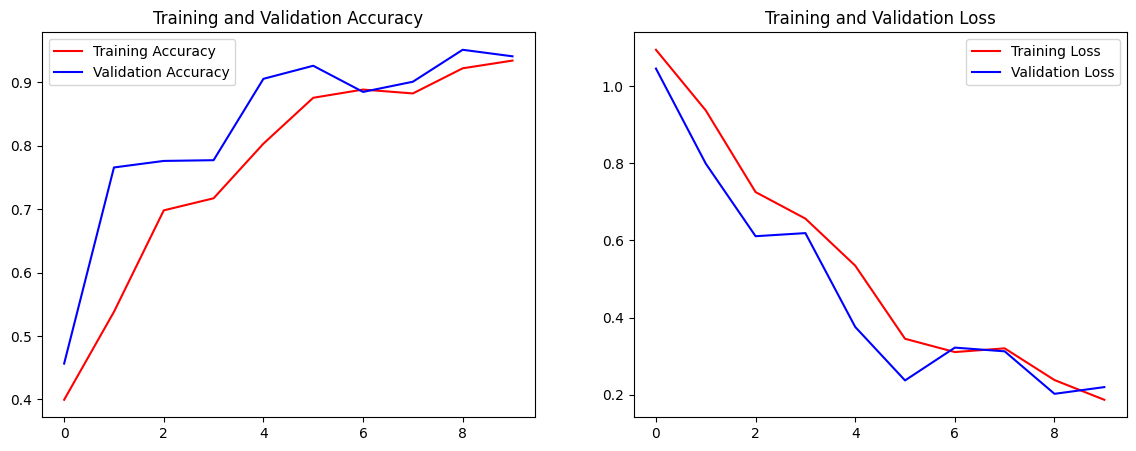

In [8]:
eval_plot(history)
evaluate(model)

# Fungsi Memprediksi Gambar

---

Menggunakan Fungsi **predict_image** untuk memuat model, memuat dan mengubah ukuran gambar, melakukan prediksi, dan menampilkan hasil prediksi.

In [13]:
def predict_image(image_upload, model = model):
  gambar = image_upload
  gambar_array = np.asarray(gambar)
  gambar_array = gambar_array*(1/225)
  gambar_input = tf.reshape(gambar_array, shape = [1, 100, 150, 3])

  predict_proba = sorted(model.predict(gambar_input)[0])[2]
  predict_class = np.argmax(model.predict(gambar_input))

  if predict_class == 0:
      predict_label = 'Paper'
  elif predict_class == 1:
      predict_label = 'Rock'
  else:
      predict_label = 'Scissor'

  print('\n')
  plt.show()
  print("\nImage prediction result: ", predict_label)
  print("Probability: ", round(predict_proba*100,2), "%")
  print('\n')

Saving yaRRMcZS7JJ3xLK1.png to yaRRMcZS7JJ3xLK1 (2).png
1/1 [==============================] - 0s 28ms/step




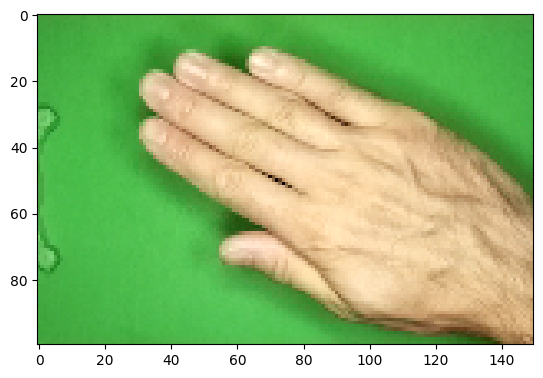


Image prediction result:  Paper
Probability:  98.86 %




In [14]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(100,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

predict_image(img)